# Import Statements

In [1]:
import os, pickle, math, random
import numpy as np
import pandas as pd
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

In [2]:
seed = 42
random.seed(seed) 
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class DialogueActDataset(Dataset):
    # Custom PyTorch Dataset for dialogue-act classification.
    def __init__(self, data_path, vocab_path, label2id, max_len=50,
                 token_col="Tokens", label_col="Act"):
        self.data = pd.read_pickle(data_path)
        with open(vocab_path, "rb") as f:
            self.vocab = pickle.load(f)
        self.label2id = label2id
        self.token_col = token_col
        self.label_col = label_col
        self.max_len = max_len
        self.data = self.data[self.data[self.label_col].isin(self.label2id.keys())].reset_index(drop=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        tokens = row[self.token_col]
        label  = row[self.label_col]

        ids = [self.vocab.get(t, self.vocab["<UNK>"]) for t in tokens]
        ids = ids[:self.max_len]
        ids += [self.vocab["<PAD>"]] * (self.max_len - len(ids))

        return torch.tensor(ids, dtype=torch.long), torch.tensor(self.label2id[label], dtype=torch.long)

In [4]:
train_pkl = "../data/processed/dd_train_tokenized.pkl"
val_pkl   = "../data/processed/dd_val_tokenized.pkl"
test_pkl  = "../data/processed/dd_test_tokenized.pkl"
vocab_pkl = "../data/processed/vocab.pkl"

dd_train = pd.read_pickle(train_pkl)
acts_in_train = sorted(dd_train["Act"].unique().tolist())
acts_in_train

[1, 2, 3, 4]

In [5]:
label2id = {a: a for a in acts_in_train}
id2label = {
    1: 'inform', 2: 'question', 3: 'directive', 4: 'commissive'
}

print(label2id)
print()
print(id2label)

{1: 1, 2: 2, 3: 3, 4: 4}

{1: 'inform', 2: 'question', 3: 'directive', 4: 'commissive'}


In [6]:
with open(vocab_pkl, "rb") as f:
    vocab = pickle.load(f)

# Data loader

In [7]:
batch_size = 32
max_len = 50

# Initialize train dataset
train_dataset = DialogueActDataset(train_pkl, 
                              vocab_pkl, 
                              label2id, 
                              max_len=max_len, 
                              label_col="Act")

# Create train dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize validation dataset
val_dataset   = DialogueActDataset(val_pkl,   
                              vocab_pkl, 
                              label2id, 
                              max_len=max_len, 
                              label_col="Act")
# Create validation dataloader
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

# Initialize test dataset
test_dataset  = DialogueActDataset(test_pkl,  
                              vocab_pkl, 
                              label2id, 
                              max_len=max_len, 
                              label_col="Act")

# Create test dataloader
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# LSTM Model

In [8]:
class LSTMActClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, pad_idx, dropout=0.5):
        # Initialize the LSTM-based dialogue act classifier model architecture.
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=False, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Forward pass embeds tokens, process via LSTM, pool features, 
        # and output class log-probabilities.
        
        emb = self.embedding(x)
        out, _ = self.lstm(emb)
        mean_pool = out.mean(dim=1)
        dropped = self.dropout(mean_pool)
        logits = self.fc(dropped)
        return self.log_softmax(logits)

    @torch.no_grad()
    def evaluate_loss(self, loader, criterion, device):
        # Compute average loss of the model over a given dataset 
        # loader without gradient updates.
        
        self.eval()
        losses, n = 0.0, 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logp = self(x)
            loss = criterion(logp, y)
            losses += loss.item(); n += 1
        return losses / max(n, 1)

    @torch.no_grad()
    def evaluate_model(self, loader, device):
        # Evaluate classification performance (Accuracy, Macro-F1) over a dataset loader.
        
        self.eval()
        all_y, all_p = [], []
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logp = self(x)
            pred = logp.argmax(dim=1)
            all_y.extend(y.cpu().numpy())
            all_p.extend(pred.cpu().numpy())
        acc = accuracy_score(all_y, all_p)
        macro_f1 = f1_score(all_y, all_p, average="macro")
        return acc, macro_f1

    def fit(self, 
            train_loader, 
            val_loader, 
            criterion, 
            optimizer, 
            epochs,
            device, 
            best_path="../models/checkpoints/act_best_weights.pt",
            last_path="../models/checkpoints/act_last_weights.pt",
            clip_grad=None):
        # Train the model for multiple epochs, saving best and last checkpoints.
        
        os.makedirs(os.path.dirname(best_path), exist_ok=True)
        os.makedirs(os.path.dirname(last_path), exist_ok=True)

        self.to(device)
        best_val = float("inf")
        train_losses = []
        val_losses = []

        for ep in range(1, epochs+1):
            self.train()
            total_loss, steps = 0.0, 0
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)

                optimizer.zero_grad()
                logp = self(x)
                loss = criterion(logp, y)
                loss.backward()
                if clip_grad is not None:
                    nn.utils.clip_grad_norm_(self.parameters(), clip_grad)
                optimizer.step()

                total_loss += loss.item(); steps += 1

            train_loss = total_loss / max(steps, 1)
            val_loss = self.evaluate_loss(val_loader, criterion, device)
            train_losses.append(train_loss)
            val_losses.append(val_loss)

            print(f"Epoch {ep:02d}/{epochs} | Train {train_loss:.4f} | Val {val_loss:.4f}")

            if val_loss < best_val:
                best_val = val_loss
                torch.save(self.state_dict(), best_path)

        torch.save(self.state_dict(), last_path)

        print("\nBest model saved!!\n")
        print("Training completed!\n")

        train_acc, train_macro_f1 = self.evaluate_model(train_loader, device)
        print(f"\nFinal Train Accuracy: {train_acc:.4f}")
        print(f"Final Train Macro F1: {train_macro_f1:.4f}")
        
        val_acc, val_macro_f1 = self.evaluate_model(val_loader, device)
        print(f"\nFinal Validation Accuracy: {val_acc:.4f}")
        print(f"Final Validation Macro F1: {val_macro_f1:.4f}")
    
        return train_losses, val_losses

    def plot_loss_curves(self, train_losses, val_losses, name):
        # Plot training and validation loss curves.
        
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(f"Train and Validation Loss Curve for {name}")
        plt.legend()
        plt.grid(True)
        plt.show()

    def classify_dialogue_act(self, dataset):
            # Predict emotions for some sample utterances from the test dataset
            # to see the performance of the model
            
            id2label = {
                1: "inform",
                2: "question",
                3: "directive",
                4: "commissive"
            }
            index = [5639, 75, 4225, 1796, 568, 2551, 6223, 2324]
            
            for i in index:
                row = dataset.data.iloc[i]
                text = row["Utterance"]
            
                input_ids, label = dataset[i]
                input_ids = input_ids.unsqueeze(0).to(device)
            
                with torch.no_grad():
                    output = self(input_ids)
                    pred = torch.argmax(output, dim=1).item()
            
                print("Utterance:", text)
                print("True:", id2label[int(label.item())], "| Predicted:", id2label[pred])
                print()

In [9]:
vocab_size = len(vocab)
pad_idx = vocab["<PAD>"]
output_dimen = max(label2id.values()) + 1

embed_dimen = 128
hidden_dimen = 64
droupout = 0.5
epochs = 10
lr = 1e-3

In [10]:
# Initialise the model, optimizer and criterion
model = LSTMActClassifier(
    vocab_size=vocab_size,
    embed_dim=embed_dimen,
    hidden_dim=hidden_dimen,
    output_dim=output_dimen,
    pad_idx=pad_idx,
    dropout=droupout
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr)
criterion = nn.NLLLoss()

# Model Training

In [11]:
# Train the model
ckpt_dir = "../models/checkpoints/act_classifier/tuning"
best_ckpt = os.path.join(ckpt_dir, "act_classifier_best.pt")
last_ckpt = os.path.join(ckpt_dir, "act_classifier_last.pt")

train_losses, val_losses = model.fit(train_loader, 
          val_loader, 
          criterion, 
          optimizer, 
          epochs,
          device=device, 
          best_path=best_ckpt, 
          last_path=last_ckpt, 
          clip_grad=1.0)

Epoch 01/10 | Train 1.0978 | Val 1.0356
Epoch 02/10 | Train 0.9471 | Val 0.9889
Epoch 03/10 | Train 0.8730 | Val 0.9816
Epoch 04/10 | Train 0.8089 | Val 0.9715
Epoch 05/10 | Train 0.7495 | Val 1.0031
Epoch 06/10 | Train 0.6940 | Val 1.0152
Epoch 07/10 | Train 0.6477 | Val 1.0411
Epoch 08/10 | Train 0.6016 | Val 1.0951
Epoch 09/10 | Train 0.5627 | Val 1.1744
Epoch 10/10 | Train 0.5307 | Val 1.1857

Best model saved!!

Training completed!


Final Train Accuracy: 0.8359
Final Train Macro F1: 0.7864

Final Validation Accuracy: 0.6177
Final Validation Macro F1: 0.5708


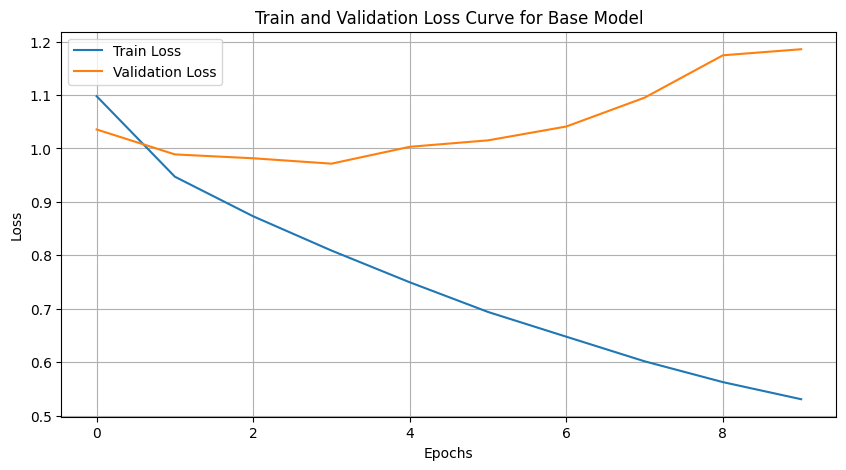

In [12]:
# Plot the loss curve
model.plot_loss_curves(train_losses, val_losses, "Base Model")

# Testing the model

In [13]:
acc, macro_f1 = model.evaluate_model(test_loader, device)
print(f"Accuracy: {acc:.4f}, Macro F1: {macro_f1:.4f}")

Accuracy: 0.6491, Macro F1: 0.5856


# Check predictions

In [14]:
model.classify_dialogue_act(test_dataset)

Utterance:  You'd better pay more attention to your health . 
True: directive | Predicted: directive

Utterance:  A good rest is all you need , and drink more water . I'll write you a prescription . 
True: directive | Predicted: directive

Utterance: What's wrong with you ? You look pale . 
True: question | Predicted: question

Utterance:  What am I suppose to do ? 
True: question | Predicted: inform

Utterance:  I know what you mean . I ought to wear right clothes at the right time . 
True: commissive | Predicted: question

Utterance:  Let me see . I am sorry we just have sold it out . 
True: commissive | Predicted: commissive

Utterance:  Just make yourself at home . The other guests should be arriving shortly . 
True: inform | Predicted: question

Utterance:  Not yet , I pick it up tomorrow . 
True: inform | Predicted: inform



# Hyper parameter tuning

In [15]:
hyper_parameter_variants = [
    {"embed_dim": 128, 
     "hidden_dim": 256, 
     "optim": "Adam"},
    
    {"embed_dim": 200, 
     "hidden_dim": 256, 
     "optim": "AdamW"},
]

def fine_tune_model(variants):
    # Train and evaluate the BiLSTMEmotionClassifier for multiple hyperparameter configurations.
    
    i = 1
    for variant in variants:
        print(f"Training the model with parameters: {variant}")
        print()

        model = LSTMActClassifier(
            vocab_size=vocab_size,
            embed_dim = variant["embed_dim"], 
            hidden_dim = variant["hidden_dim"], 
            output_dim=output_dimen,
            pad_idx=pad_idx,
            dropout=droupout
        ).to(device)
        
        if variant["optim"] == "Adam":
            optimizer = torch.optim.Adam(model.parameters(), lr)

        elif variant["optim"] == "AdamW":
            optimizer = torch.optim.AdamW(model.parameters(), lr)

        variant_best_ckpt = os.path.join(ckpt_dir, f"act_classifier_best_variant{i}.pt")
        variant_last_ckpt = os.path.join(ckpt_dir, f"act_classifier_last_variant{i}.pt")

        train_losses, val_losses = model.fit(train_loader, 
          val_loader, 
          criterion, 
          optimizer, 
          epochs,
          device=device, 
          best_path=variant_best_ckpt, 
          last_path=variant_last_ckpt, 
          clip_grad=1.0
        )

        print()
        test_acc, test_macro_f1 = model.evaluate_model(test_loader, device)
        print(f"Final Test Accuracy: {test_acc:.4f}")
        print(f"Final Test Macro F1: {test_macro_f1:.4f}")

        model.plot_loss_curves(train_losses, val_losses, f"Model variant{i}")

        print("Dialog-act predictions for the model variant:")
        model.classify_dialogue_act(test_dataset)
        i += 1
        print()

Training the model with parameters: {'embed_dim': 128, 'hidden_dim': 256, 'optim': 'Adam'}

Epoch 01/10 | Train 1.0557 | Val 1.0075
Epoch 02/10 | Train 0.9147 | Val 0.9630
Epoch 03/10 | Train 0.8279 | Val 0.9599
Epoch 04/10 | Train 0.7301 | Val 0.9773
Epoch 05/10 | Train 0.6237 | Val 0.9978
Epoch 06/10 | Train 0.5278 | Val 1.1326
Epoch 07/10 | Train 0.4539 | Val 1.2236
Epoch 08/10 | Train 0.3965 | Val 1.3234
Epoch 09/10 | Train 0.3570 | Val 1.4700
Epoch 10/10 | Train 0.3254 | Val 1.4592

Best model saved!!

Training completed!


Final Train Accuracy: 0.9081
Final Train Macro F1: 0.8776

Final Validation Accuracy: 0.6218
Final Validation Macro F1: 0.5707

Final Test Accuracy: 0.6615
Final Test Macro F1: 0.5931


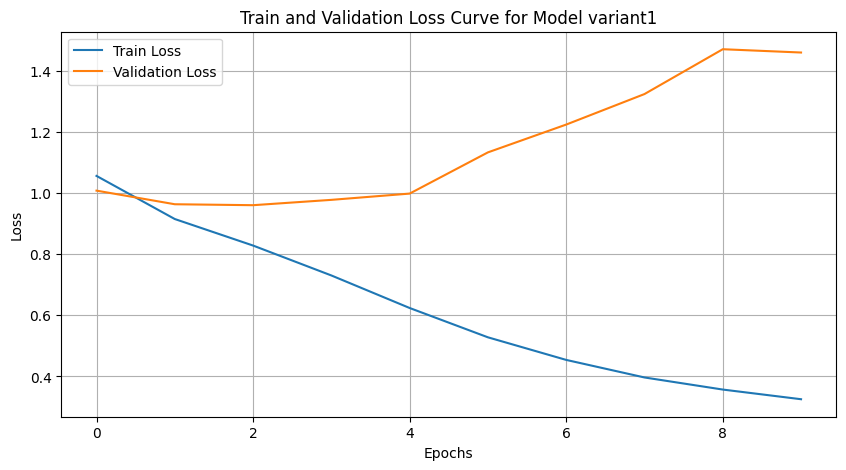

Dialog-act predictions for the model variant:
Utterance:  You'd better pay more attention to your health . 
True: directive | Predicted: directive

Utterance:  A good rest is all you need , and drink more water . I'll write you a prescription . 
True: directive | Predicted: commissive

Utterance: What's wrong with you ? You look pale . 
True: question | Predicted: question

Utterance:  What am I suppose to do ? 
True: question | Predicted: inform

Utterance:  I know what you mean . I ought to wear right clothes at the right time . 
True: commissive | Predicted: inform

Utterance:  Let me see . I am sorry we just have sold it out . 
True: commissive | Predicted: commissive

Utterance:  Just make yourself at home . The other guests should be arriving shortly . 
True: inform | Predicted: inform

Utterance:  Not yet , I pick it up tomorrow . 
True: inform | Predicted: directive


Training the model with parameters: {'embed_dim': 200, 'hidden_dim': 256, 'optim': 'AdamW'}

Epoch 01/10 | Trai

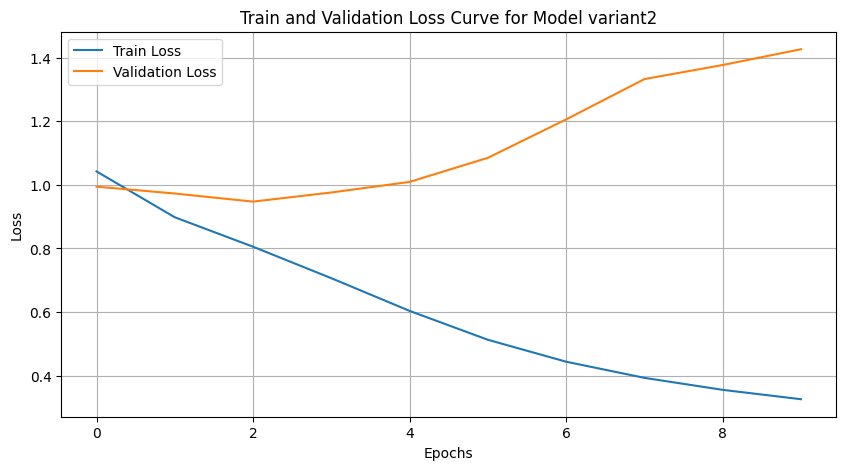

Dialog-act predictions for the model variant:
Utterance:  You'd better pay more attention to your health . 
True: directive | Predicted: directive

Utterance:  A good rest is all you need , and drink more water . I'll write you a prescription . 
True: directive | Predicted: directive

Utterance: What's wrong with you ? You look pale . 
True: question | Predicted: question

Utterance:  What am I suppose to do ? 
True: question | Predicted: inform

Utterance:  I know what you mean . I ought to wear right clothes at the right time . 
True: commissive | Predicted: directive

Utterance:  Let me see . I am sorry we just have sold it out . 
True: commissive | Predicted: commissive

Utterance:  Just make yourself at home . The other guests should be arriving shortly . 
True: inform | Predicted: question

Utterance:  Not yet , I pick it up tomorrow . 
True: inform | Predicted: directive




In [16]:
fine_tune_model(hyper_parameter_variants)

Analysis:
 - The base model is showing a test accuracy of 64.91% and a Macro F1 score of 0.5856
 - The hyper parameter variant 1 model is showing a test accuracy of 66.15% and a Macro F1 score of 0.5931
 - The hyper parameter variant 2 model is showing a test accuracy of 66.47% and a Macro F1 score of 0.5930
 - The hyper parameter tuning has worked to improve the base performance of the dialogue act classifier model.
 - Since the model with hyper parameter variant 2 is showing a better output, considering this model for dialogue act classifier model.